## 補充 : Generator

In [27]:
import pandas as pd
import os
import sys
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
data_dir = '../datasets/aia-data/cat_dog/train/'

In [5]:
data_list = os.listdir(data_dir)
print(len(data_list))

25000


## Read single file

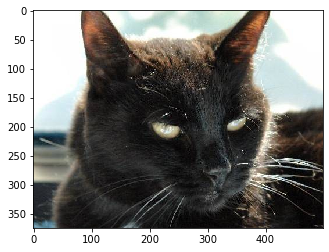

In [10]:
img_path = os.path.join(data_dir, data_list[0])

img = cv2.imread(img_path)
plt.imshow(img[:,:,::-1])

## Read all files

In [22]:
imgs = [cv2.imread(os.path.join(data_dir, i)) for i in data_list]

total_size = 0
for i in imgs:
    total_size += sys.getsizeof(i)/1024/1024/1024 # from bytes to gigabytes
print(total_size)

10.563367307186127


為了保護世界的和平，請大家盡量不要在大量資料上使用這個方式...

---

## Read batch of files

在進行深度學習模型訓練時，我們的需求大概是
1. 減少無謂的記憶體占用 (mini-batch updating)
2. 每個epoch中隨機讀取資料

因此比較常見的做法是，每次只讀取這個批次所需的資料數量(ex.32張影像)，在計算完梯度並更新完網路時再去讀取下個批次的影像。

### 1. Use ImageDataGenerator provided by keras!

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# https://keras.io/preprocessing/image/

In [37]:
gen = ImageDataGenerator()

# gen.flow_from_directory()

# gen.flow()

# gen.flow_from_dataframe()

In [28]:
data_list[0]

'cat.9042.jpg'

In [30]:
# make dataframe yourself
train_df = pd.DataFrame({'file_path':data_list, 'label':[i.split('.')[0] for i in data_list]})

In [38]:
train_generator = gen.flow_from_dataframe(dataframe=train_df, directory=data_dir, x_col='file_path', y_col='label')

Found 25000 validated image filenames belonging to 2 classes.


In [39]:
# take next batch of images and labels
out_x, out_y = next(train_generator)

In [40]:
print(out_x.shape, out_y.shape)

(32, 256, 256, 3) (32, 2)


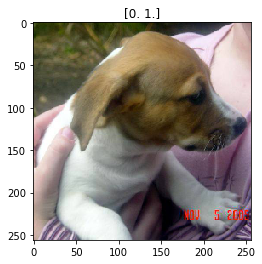

In [47]:
plt.imshow(out_x[0].astype('int'))
plt.title(out_y[0])
plt.show()

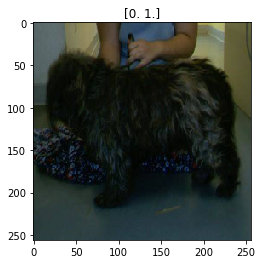

In [52]:
# take another batch of images and labels
out_x, out_y = next(train_generator)

plt.imshow(out_x[0].astype('int'))
plt.title(out_y[0])
plt.show()

### Must-know Tips

- keras 內建的 ImageDataGenerator 可協助批次讀取資料、前處理、資料擴增，搭配model.fit_generator可滿足大部分人的需求
---

### 2. Customize your own generator !


- 可參考
    - Python_part2/Functions.ipynb
    - cvcnn_part5/U-Net.ipynb

In [55]:
# 一個簡單的generator
def random(N):
    import random
    
    L = [i for i in range(N)]
    random.shuffle(L)
    
    for v in L:
        yield v
    
    print('end')

In [58]:
Deck = random(5)

print(next(Deck))
print(next(Deck))
print(next(Deck))
print(next(Deck))
print(next(Deck))

print(next(Deck))

4
2
3
1
0
end


StopIteration: 

---
Task : 自動上色模型

    - Input : Gray Scale Image
    - Output : Same Image with color

In [70]:
from random import shuffle
import numpy as np

In [94]:
def customize_generator(data_dir,re_size=(256, 256), batch_size=32, shuffle_=True):
    
    file_list = os.listdir(data_dir)
    x_list = [] ;y_list = []
    
    # 為了訓練時可以不間斷地重複使用這個generator，在最外層增加while True
    while True:
        if shuffle_:
            shuffle(file_list)

        for i, img_path in enumerate(file_list):
            img = cv2.imread(os.path.join(data_dir, img_path))
            img = cv2.resize(img, re_size)
            img_g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            x_list.append(img_g)
            y_list.append(img)

            if len(x_list)==batch_size:
                out_x = np.array(x_list)
                out_y = np.array(y_list)

                x_list=[]; y_list=[]
                yield out_x, out_y

In [95]:
cust_gen = customize_generator(data_dir=data_dir)

In [96]:
g_img, c_img = next(cust_gen)

In [98]:
print(g_img.shape, c_img.shape)

(32, 256, 256) (32, 256, 256, 3)


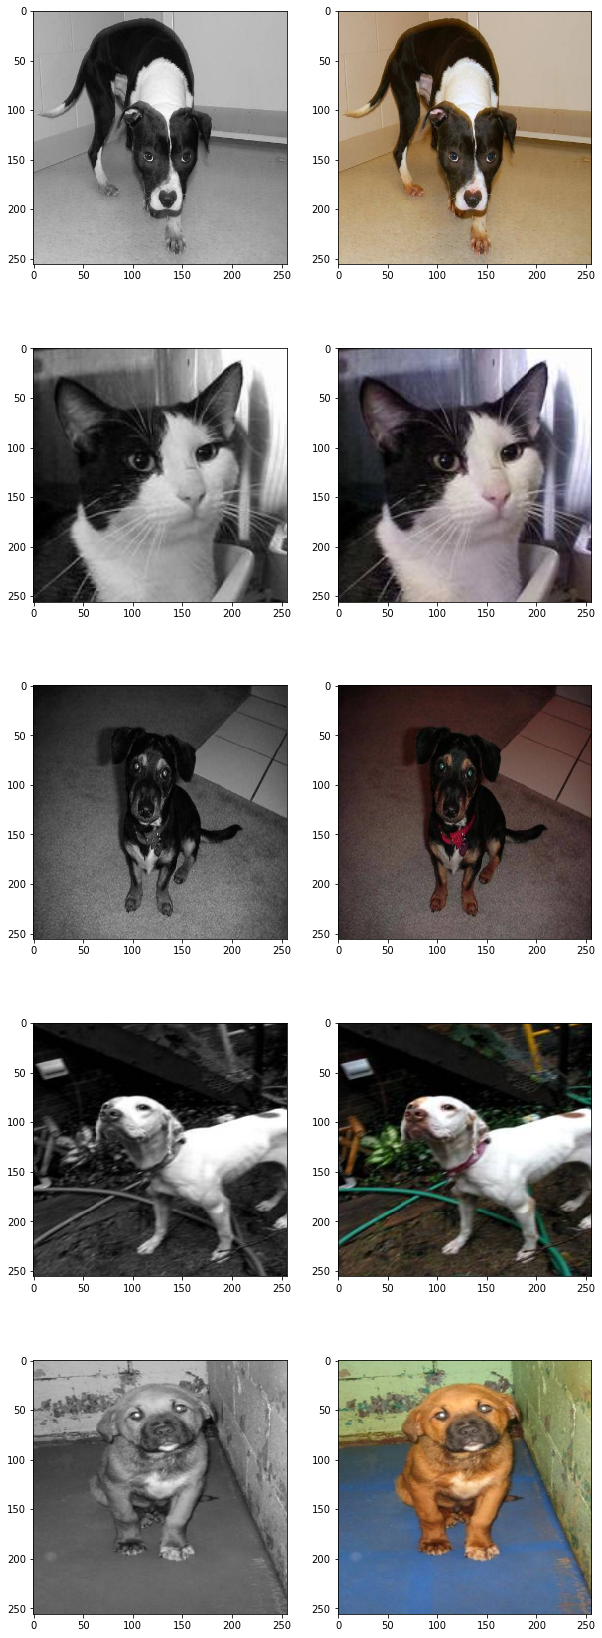

In [120]:
f, ax = plt.subplots(5,2, figsize=(10, 30))

for i in range(5):
    ax[i, 0].imshow(g_img[i].astype('int'), 'gray')
    ax[i, 1].imshow(c_img[i,:,:,::-1].astype('int'))

In [130]:
%%time

cust_gen = customize_generator(data_dir=data_dir, batch_size=256)

for i in range(100):
    g_img, c_img = next(cust_gen)

print('end')


end
CPU times: user 1min 18s, sys: 2.12 s, total: 1min 20s
Wall time: 1min 20s


注意到這邊我們其實讀取超過25000張影像，但生成器仍然不會停止

---

上面的imagedatagenerator還可以多加甚麼

- Rescaling
- Other preprocessing function
- Data Augmentation
- 其他ImageDataGenerator有但我們沒有的東西